This notebook has regression models to predict number of transactions given the timestamp.

The data is based on an hourly basis (for accuracy issues)

# Deposit

Import libraries

In [347]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

Get the dataset

In [348]:
deposit_raw = pd.read_csv("deposit2019.csv")
successfulVends_raw = pd.read_csv("successfulVENDS2019.csv")

Retrieve columns and rename columns

In [349]:
deposit = deposit_raw[["systemtranstime","transamount"]]

deposit= deposit.rename(index=str,columns={"transamount":"amount","systemtranstime":"time"})

Convert time to datetime

In [350]:
deposit['time']=pd.to_datetime(deposit.time)


Normalization function

In [351]:
def normalize(z):
    x = z
    x = x.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(np.vstack(x))
    return x_scaled

Get number of transactions hourly

In [352]:
deposit_hour = deposit.resample('30min', on='time').count().drop('time',axis=1)



In [353]:
#deposit_hour = deposit

Normalize the number of transactions

In [354]:
deposit_hour['amount']=normalize(deposit_hour['amount'])


Get the train and test dataset
train: is the first 2 months
test: is the third month

In [355]:
train = deposit_hour[deposit_hour.index.month<3]
test = deposit_hour[deposit_hour.index.month==3]

## STL Decomposition

In [356]:
plt.rcParams['figure.figsize']=[19,7]
res = seasonal_decompose(train,model='additive')
resplot = res.plot()

ValueError: freq T not understood. Please report if you think this is in error.

It captures the seasonality.

Renaming column to be able to pass to fb prophet's algorithm

In [ ]:
df = deposit_hour.reset_index().rename(index=str,columns={"amount":"y","time":"ds"})
train_fb = df[df.ds.dt.month<3]
test_fb = df[df.ds.dt.month==3]

Create instance of prophet and fit data 

In [ ]:
m = Prophet()
m.fit(train_fb)

Predict up to the following month even after two months passed

In [ ]:
future = m.make_future_dataframe(periods=616,freq='H')
future.tail()

Make predictions

In [ ]:
forecast = m.predict(future)
forecast.tail()

Show forecast

Get the r2 score of the train and test

In [ ]:
#extract train only
forecast_train  = forecast[forecast.ds.dt.month<3]

r2_score(train_fb.y,forecast_train.yhat)

In [ ]:
#extract test
forecast_test  = forecast[forecast.ds.dt.month==3]
r2_score(test_fb.y,forecast_test.yhat)

In [ ]:
fig1 = m.plot(forecast)

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [ ]:
deposit_hour['hour'] = deposit_hour.index.hour
deposit_hour['week'] =  deposit_hour.index.week
deposit_hour['month'] =  deposit_hour.index.month
deposit_hour['day_of_week'] =  deposit_hour.index.dayofweek
deposit_hour['previous_amount'] =  deposit_hour.amount.shift(1)
deposit_hour.head()

Create a train and test dataset of the decomposed timestamp dataframe

In [ ]:
train_decompose = deposit_hour[deposit_hour.index.month<3]
test_decompose = deposit_hour[deposit_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [ ]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=7, random_state=15,n_estimators=22)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

Creating dataframe to plot predictions and actual with ease

In [ ]:
#using test
predictions= test
predictions['predictions'] = y_

In [ ]:
predictions.plot()

In [ ]:
#using train
pred= train
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=50)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

## Stack Regressor

In [ ]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=7, random_state=16,n_estimators=22)

neigh = KNeighborsRegressor(n_neighbors=58)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


In [ ]:
#using test
predictions= test
predictions['predictions'] = y_
predictions.plot()

## Successful Vends

In [399]:
successfulVends = successfulVends_raw[["time","amount"]]

successfulVends.head()

,time,amount
0,2019-01-01 06:59:57,1
1,2019-01-02 07:40:31,300
2,2019-01-02 07:41:16,100
3,2019-01-02 07:41:12,900
4,2019-01-02 10:41:37,700


Convert time to datetime

In [400]:
successfulVends['time']=pd.to_datetime(successfulVends.time)


Get number of transactions hourly

In [417]:
successfulVends_hour = successfulVends.resample('10min', on='time').count().drop('time',axis=1)
successfulVends_hour


,amount
time,
2019-01-01 06:50:00,1
2019-01-01 07:00:00,0
2019-01-01 07:10:00,0
2019-01-01 07:20:00,0
2019-01-01 07:30:00,0
2019-01-01 07:40:00,0
2019-01-01 07:50:00,0
2019-01-01 08:00:00,0
2019-01-01 08:10:00,0


Normalize the values

In [418]:
successfulVends_hour['amount']=normalize(successfulVends_hour['amount'])
successfulVends_hour

,amount
time,
2019-01-01 06:50:00,0.001845
2019-01-01 07:00:00,0.000000
2019-01-01 07:10:00,0.000000
2019-01-01 07:20:00,0.000000
2019-01-01 07:30:00,0.000000
2019-01-01 07:40:00,0.000000
2019-01-01 07:50:00,0.000000
2019-01-01 08:00:00,0.000000
2019-01-01 08:10:00,0.000000


Get the train and test dataset
train: is the first 2 months
test: is the third month

In [419]:
train = successfulVends_hour[successfulVends_hour.index.month<3]
test = successfulVends_hour[successfulVends_hour.index.month==3]

## STL Decomposition

In [420]:
plt.rcParams['figure.figsize']=[19,7]
res = seasonal_decompose(train,model='additive')
resplot = res.plot()

ValueError: freq T not understood. Please report if you think this is in error.

It captures the seasonality.

Renaming column to be able to pass to fb prophet's algorithm

In [ ]:
df = successfulVends_hour.reset_index().rename(index=str,columns={"amount":"y","time":"ds"})
train_fb = df[df.ds.dt.month<3]
test_fb = df[df.ds.dt.month==3]

Create instance of prophet and fit data 

In [ ]:
m = Prophet()
m.fit(train_fb)

Predict up to the following month even after two months passed

In [ ]:
future = m.make_future_dataframe(periods=616,freq='H')
future.tail()

Make predictions

In [ ]:
forecast = m.predict(future)
forecast.tail()

Show forecast

Get the r2 score of the train and test

In [ ]:
#extract train only
forecast_train  = forecast[forecast.ds.dt.month<3]

r2_score(train_fb.y,forecast_train.yhat)

In [ ]:
#extract test
forecast_test  = forecast[forecast.ds.dt.month==3]
r2_score(test_fb.y,forecast_test.yhat)

In [ ]:
fig1 = m.plot(forecast)

### Classification Trees

Breakdown timestamp to other features so as to pass it to regressors i.e hour,day and day of the week

In [421]:
successfulVends_hour['hour'] = successfulVends_hour.index.hour
successfulVends_hour['week'] =  successfulVends_hour.index.week
successfulVends_hour['month'] =  successfulVends_hour.index.month
successfulVends_hour['day_of_week'] =  successfulVends_hour.index.dayofweek
successfulVends_hour['previous_amount'] =  successfulVends_hour.amount.shift(1)

successfulVends_hour=  successfulVends_hour.dropna()

successfulVends_hour.head()

,amount,hour,week,month,day_of_week,previous_amount
time,,,,,,
2019-01-01 07:00:00,0.0,7,1,1,1,0.001845
2019-01-01 07:10:00,0.0,7,1,1,1,0.000000
2019-01-01 07:20:00,0.0,7,1,1,1,0.000000
2019-01-01 07:30:00,0.0,7,1,1,1,0.000000
2019-01-01 07:40:00,0.0,7,1,1,1,0.000000


Create a train and test dataset of the decomposed timestamp dataframe

In [422]:
train_decompose = successfulVends_hour[successfulVends_hour.index.month<3]
test_decompose = successfulVends_hour[successfulVends_hour.index.month==3]

Create train and test matrices without y column to pass to regression models

In [423]:
X_train = train_decompose.drop(columns=['amount']) 
X_test = test_decompose.drop(columns=['amount']) 

y_train = train_decompose.amount
y_test = test_decompose.amount

Import libraries for the model

In [424]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
 
#these are the hyperparameters that yielded the best test results (no grid search)
clf = RandomForestRegressor(max_depth=5, random_state=16,n_estimators=21)
clf.fit(X_train, y_train) 

y_ = clf.predict(X_test)
y_pred = clf.predict(X_train)

#get r_score
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.60412061386 			 0.469178434617


Creating dataframe to plot predictions and actual with ease

In [425]:
#using test
predictions= test
predictions['predictions'] = y_

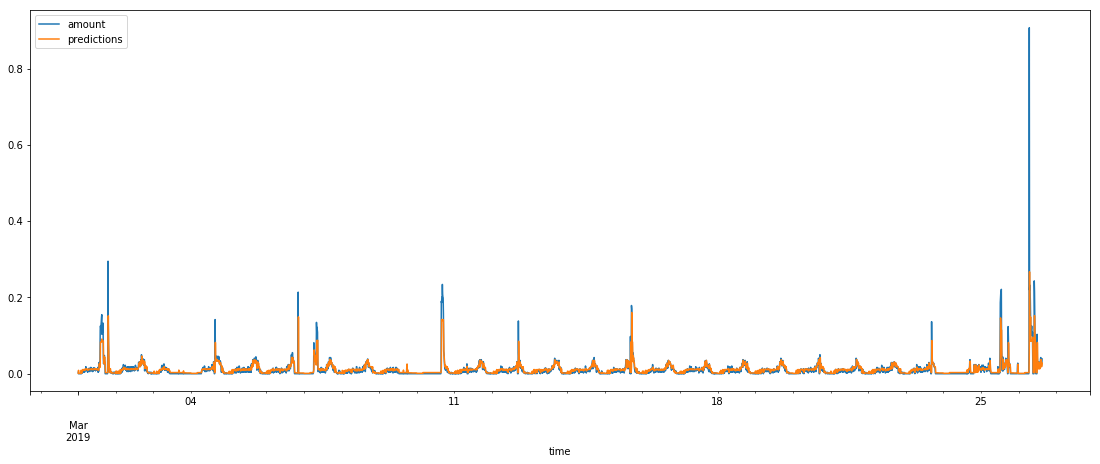

In [426]:
predictions.plot()

In [427]:
train.count()

amount    8455
dtype: int64

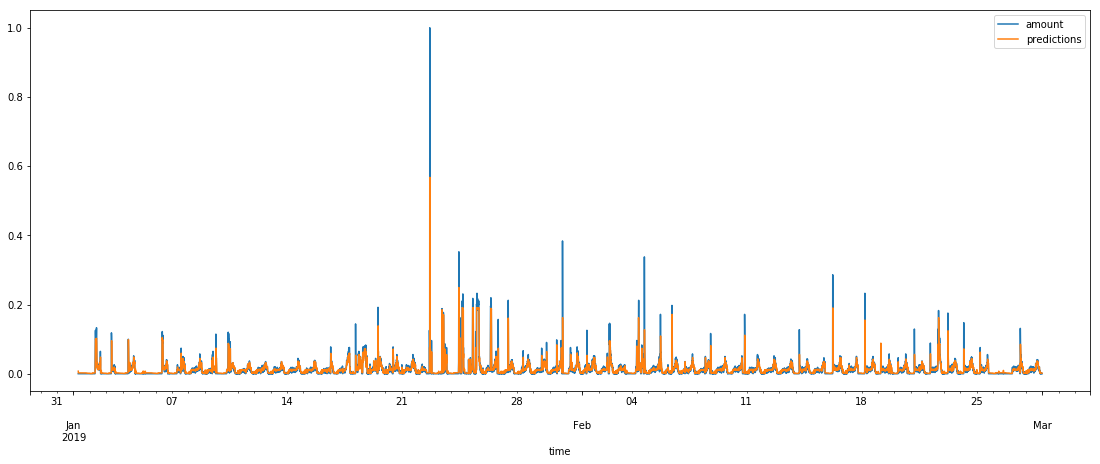

In [428]:
#using train
pred= train[1:]
pred['predictions'] = y_pred
pred.plot()

## KNN Regressor


In [429]:
from sklearn.neighbors import KNeighborsRegressor

#number of neighbours with best results (no grid search)
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(X_train, y_train) 
    
y_ = neigh.predict(X_test)
y_pred = neigh.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.572818321578 			 0.0531840273866


## Linear Regression

In [430]:
from sklearn.linear_model import LinearRegression

#no tuning of hyperparameters
reg = LinearRegression().fit(X_train, y_train)
y_ = reg.predict(X_test)
y_pred = reg.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))

0.517777416866 			 0.40682991025


## Stack Regressor

In [431]:
#Ensemble(stacking) for regressors (not sure how it works)
from mlxtend.regressor import StackingRegressor

#use the three algorithms
lr = LinearRegression()
rfr = RandomForestRegressor(max_depth=2, random_state=16,n_estimators=21)

neigh = KNeighborsRegressor(n_neighbors=65)
stregr = StackingRegressor(regressors=[rfr, lr, neigh], 
                           meta_regressor=neigh)

# Training the stacking classifier

stregr.fit(X_train, y_train) 

y_ = stregr.predict(X_test)
y_pred = stregr.predict(X_train)

#r2_score for train and test
print(r2_score(y_train, y_pred),'\t\t\t',r2_score(y_test, y_))


0.54081998626 			 0.473902849004


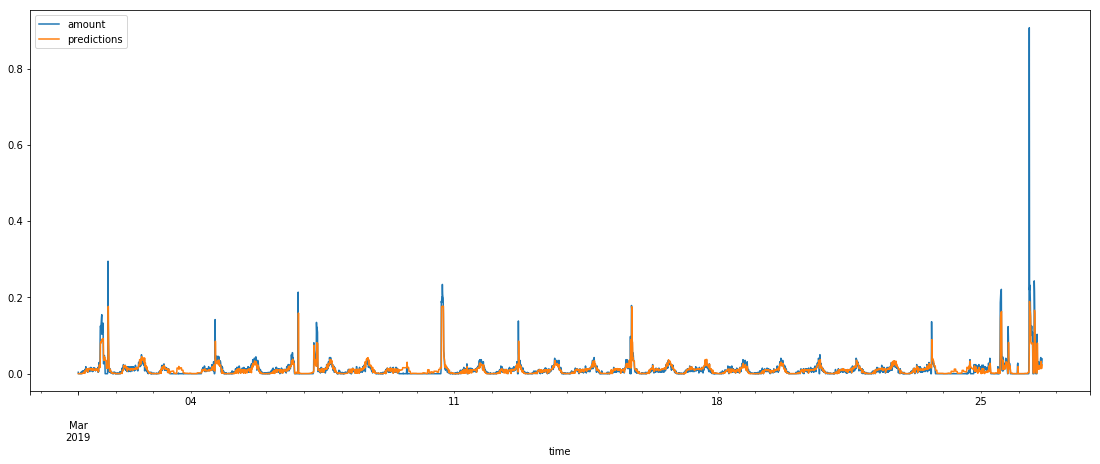

In [432]:
#using test
predictions= test
predictions['predictions'] = y_
predictions.plot()

## Deposit and Successful Vends